<a href="https://colab.research.google.com/github/lfisher2024/DataDemo/blob/main/Colab_alexnet_test_and_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using dataset at: /content/drive/MyDrive/AI class/Fire Alexnet /fire images
Train directory: /content/drive/MyDrive/AI class/Fire Alexnet /fire images/Train
Test directory:  /content/drive/MyDrive/AI class/Fire Alexnet /fire images/Test
✅ Training on: cpu

✅ Found 24 training images and 15 testing images.
✅ Classes: ['Fire', 'No Fire']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 132MB/s]



Epoch 1/15
-------------------------
Train Loss: 0.8216 | Acc: 0.4167
Test Loss: 0.7307 | Acc: 0.6000

Epoch 2/15
-------------------------
Train Loss: 0.6919 | Acc: 0.5417
Test Loss: 0.7156 | Acc: 0.5333

Epoch 3/15
-------------------------
Train Loss: 0.3376 | Acc: 0.7917
Test Loss: 0.7206 | Acc: 0.6000

Epoch 4/15
-------------------------
Train Loss: 0.1835 | Acc: 0.9583
Test Loss: 0.6977 | Acc: 0.6667

Epoch 5/15
-------------------------
Train Loss: 0.1177 | Acc: 1.0000
Test Loss: 0.6557 | Acc: 0.7333

Epoch 6/15
-------------------------
Train Loss: 0.0515 | Acc: 1.0000
Test Loss: 0.5927 | Acc: 0.8000

Epoch 7/15
-------------------------
Train Loss: 0.0246 | Acc: 1.0000
Test Loss: 0.5485 | Acc: 0.8000

Epoch 8/15
-------------------------
Train Loss: 0.0167 | Acc: 1.0000
Test Loss: 0.5447 | Acc: 0.8000

Epoch 9/15
-------------------------
Train Loss: 0.0082 | Acc: 1.0000
Test Loss: 0.5407 | Acc: 0.8000

Epoch 10/15
-------------------------
Train Loss: 0.0173 | Acc: 1.0000
T

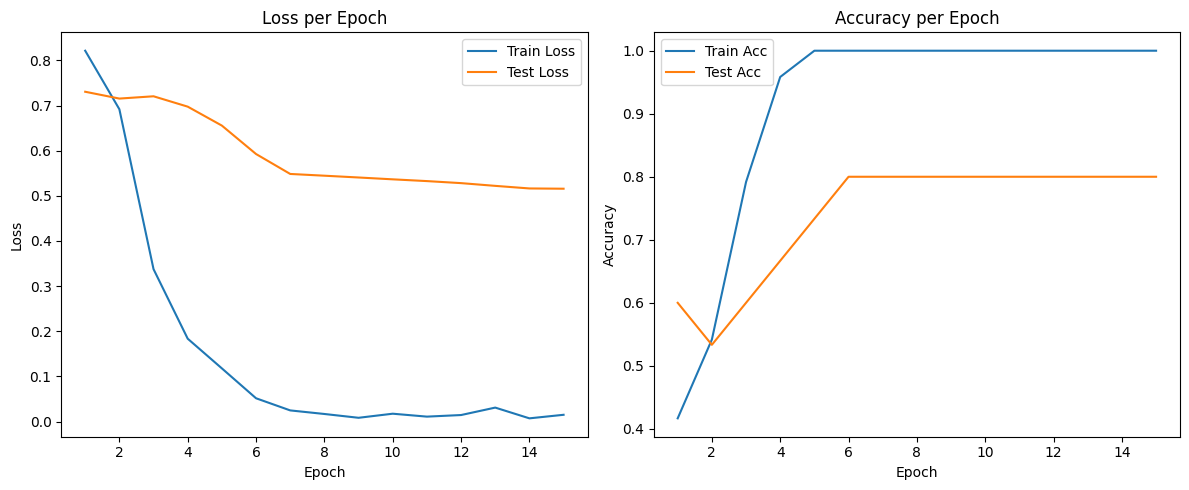

In [5]:
# ======================================
# 🔥 AlexNet Training on Fire Dataset (PyTorch)
# Organized under:
# /content/drive/MyDrive/AI class/Fire Alexnet /fire images/{Train, Test}
# ======================================

import os, time
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ---------- 1) Mount Google Drive ----------
from google.colab import drive
drive.mount('/content/drive')

# ✅ Path to dataset (includes trailing space before '/fire images')
DATA_DIR = "/content/drive/MyDrive/AI class/Fire Alexnet /fire images"

# Normalize folder names for safety (handles trailing spaces or inconsistent capitalization)
DATA_DIR = DATA_DIR.strip()
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"❌ Dataset not found at: {DATA_DIR}. Check folder names in your Drive.")

train_dir = os.path.join(DATA_DIR, "Train")
test_dir  = os.path.join(DATA_DIR, "Test")

if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    raise FileNotFoundError("❌ Could not find 'Train' or 'Test' subfolders inside your dataset directory.")

print(f"✅ Using dataset at: {DATA_DIR}")
print(f"Train directory: {train_dir}")
print(f"Test directory:  {test_dir}")

# ---------- 2) Device setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Training on: {device}")

# ---------- 3) Hyperparameters ----------
num_epochs = 15
batch_size = 32
lr = 0.001
momentum = 0.9
save_model_path = "/content/alexnet_fire_model.pth"

# ---------- 4) Transforms ----------
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# ---------- 5) Load datasets ----------
image_datasets = {
    'Train': datasets.ImageFolder(train_dir, transform=data_transforms['Train']),
    'Test':  datasets.ImageFolder(test_dir,  transform=data_transforms['Test'])
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
    for x in ['Train', 'Test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes
num_classes = len(class_names)

print(f"\n✅ Found {dataset_sizes['Train']} training images and {dataset_sizes['Test']} testing images.")
print(f"✅ Classes: {class_names}")

# ---------- 6) Build AlexNet ----------
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ---------- 7) Training loop ----------
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=15, device='cpu'):
    history = defaultdict(list)
    best_acc = 0.0
    best_weights = None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 25)

        for phase in ['Train', 'Test']:
            model.train() if phase == 'Train' else model.eval()
            running_loss, running_corrects, total = 0.0, 0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        scheduler.step()

    if best_weights:
        model.load_state_dict(best_weights)
    print(f"\n✅ Training complete! Best Test Accuracy: {best_acc:.4f}")
    return model, history

# ---------- 8) Train model ----------
trained_model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device)

# ---------- 9) Save model ----------
torch.save(trained_model.state_dict(), save_model_path)
print(f"✅ Model saved to {save_model_path}")

# ---------- 10) Plot results ----------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history['Train_loss'], label='Train Loss')
plt.plot(epochs, history['Test_loss'], label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss per Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['Train_acc'], label='Train Acc')
plt.plot(epochs, history['Test_acc'], label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch'); plt.legend()

plt.tight_layout()
plt.show()
